In [1]:
import os
from dotenv import load_dotenv
import json
import random
import matplotlib.pyplot as plt
import numpy as np
import asyncio

from benchmark import run_benchmark_sample, Trials, mark_job_failure, create_compilation_failure_trial

In [3]:
# we are currently using include_existing_trials=True and slowly increasing the number of functions
# to gather data across multiple runs
# this allows us to get initial statistics across various complexities and number of variables before the entire benchmark is complete
# we keep num_inputs=100 since these will not get filled in in future runs
crashes = []
def run_benchmark(include_existing_trials=True):
    for complexity in range(8, 21):
        for num_vars in range(16, 20):
            if (num_vars, complexity) in crashes:
                print(f"Skipping {num_vars} vars and {complexity} complexity")
                continue
            # lowering shots to 10**3 to meet new system constraint (it is either that or reduce num_inputs / split into more batches)
            run_benchmark_sample(num_vars, complexity, num_functions=5, num_inputs=100, shots=10**3, include_existing_trials=include_existing_trials, circuits_per_job=50)



In [4]:
run_benchmark()


Running benchmark sample for 16 variables and complexity 8
Number of existing trials: 5
Running benchmark sample for 17 variables and complexity 8
Number of existing trials: 5
Running benchmark sample for 18 variables and complexity 8
Number of existing trials: 5
Running benchmark sample for 19 variables and complexity 8
Number of existing trials: 5
Running benchmark sample for 16 variables and complexity 9
Number of existing trials: 5
Running benchmark sample for 17 variables and complexity 9
Number of existing trials: 5
Running benchmark sample for 18 variables and complexity 9
Number of existing trials: 5
Running benchmark sample for 19 variables and complexity 9
Number of existing trials: 5
Running benchmark sample for 16 variables and complexity 10
Number of existing trials: 5
Running benchmark sample for 17 variables and complexity 10
Number of existing trials: 5
Running benchmark sample for 18 variables and complexity 10
Number of existing trials: 5
Running benchmark sample for 

OperationalError: database is locked

In [2]:
# run this cell to load the job results for all trials that are waiting pending job results
trials = Trials()
await trials.load_results()

In [ ]:
with trials._connect() as conn:
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM trials WHERE job_id = 'cz0ja91q2bag008ybrq0'")
    rows = cursor.fetchall()
    print(rows)

In [ ]:
# run for any statement that could not be compiled to a circuit
create_compilation_failure_trial(num_vars=None, complexity=None, statement="TODO", trials=trials)

In [ ]:
# failures to execute the circuit
failed = []
for job_id in failed:
    mark_job_failure(job_id)

In [ ]:
# other failures (that should be removed from the circuit)
failed = []
for job_id in failed:
    with trials._connect() as conn:
        cursor = conn.cursor()
        cursor.execute("DELETE FROM trials WHERE job_id = ?", (job_id,))

In [ ]:
# example code to retrieve results from the first trial of 2 variables 2 complexity
trial = trials.get(num_vars=2, complexity=2)[0]
print("Experimental results:", trial.get_counts())
print("Expected:", trial.total_expected_results())
print("Number of matches:", trial.get_counts().get(trial.total_expected_results(), 0))
print("Shot count:", sum(trial.get_counts().values()))

from function_generator import get_python_function
print("Function used:", end="")
print(get_python_function(trial.statement, trial.variables))


In [5]:
def get_probability_data(trials, function_success_threshold, use_hamming=False):
    num_vars_data = []
    complexity_data = []
    probability_data = []

    for num_vars in range(2, 33):
        for complexity in range(1, 22):
            print(f"(num_vars, complexity) = ({num_vars}, {complexity})")
    
            successful_function_count = 0
            trials_by_function = trials.get_per_statement(num_vars=num_vars, complexity=complexity)
            for function in trials_by_function.keys():
                s = 0.0
                for trial in trials_by_function[function]:
                    if use_hamming:
                        s += (1-trial.mean_hamming_distance)
                    else:
                        s += trial.exact_match_rate
                    
                if s / len(trials_by_function[function]) > function_success_threshold:
                    successful_function_count += 1

            if len(trials_by_function) == 0:
                 print(f"Warning: no results for {num_vars} variables, complexity {complexity}; skipping")
                 continue
            
            num_vars_data.append(num_vars)
            complexity_data.append(complexity)
            probability_data.append(successful_function_count / len(trials_by_function))
    
    return num_vars_data, complexity_data, probability_data
    

In [6]:
trials = Trials()
num_vars_data_exact, complexity_data_exact, probability_data_exact = get_probability_data(trials, 0.8, use_hamming=False)

(num_vars, complexity) = (2, 1)
(num_vars, complexity) = (2, 2)
(num_vars, complexity) = (2, 3)
(num_vars, complexity) = (2, 4)
(num_vars, complexity) = (2, 5)
(num_vars, complexity) = (2, 6)
(num_vars, complexity) = (2, 7)
(num_vars, complexity) = (2, 8)
(num_vars, complexity) = (2, 9)
(num_vars, complexity) = (2, 10)
(num_vars, complexity) = (2, 11)
(num_vars, complexity) = (2, 12)
(num_vars, complexity) = (2, 13)
(num_vars, complexity) = (2, 14)
(num_vars, complexity) = (2, 15)
(num_vars, complexity) = (2, 16)
(num_vars, complexity) = (2, 17)
(num_vars, complexity) = (2, 18)
(num_vars, complexity) = (2, 19)
(num_vars, complexity) = (2, 20)
(num_vars, complexity) = (2, 21)
(num_vars, complexity) = (3, 1)
(num_vars, complexity) = (3, 2)
(num_vars, complexity) = (3, 3)
(num_vars, complexity) = (3, 4)
(num_vars, complexity) = (3, 5)
(num_vars, complexity) = (3, 6)
(num_vars, complexity) = (3, 7)
(num_vars, complexity) = (3, 8)
(num_vars, complexity) = (3, 9)
(num_vars, complexity) = (3,

In [ ]:
trials = Trials()
num_vars_data_hamming, complexity_data_hamming, probability_data_hamming = get_probability_data(trials, 0.8, use_hamming=True)

In [7]:

def plot_probability_data(num_vars_data, complexity_data, probability_data, title, threshold=None, filepath=None):
    if threshold is not None:
        colors = ['green' if p > threshold else 'red' for p in probability_data]
    else:
        colors = probability_data

    plt.figure(figsize=(20, 10))
    plt.scatter(num_vars_data, complexity_data, c=probability_data, cmap='RdYlGn', edgecolors='black', alpha=0.75, s=450)
    plt.xticks(np.arange(min(num_vars_data), max(num_vars_data) + 1, 1))
    plt.yticks(np.arange(min(complexity_data), max(complexity_data) + 1, 1))

    plt.xlabel('Variables Count')
    plt.ylabel('Complexity')
    plt.title(title)
    cbar = plt.colorbar()
    if filepath is not None:
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()

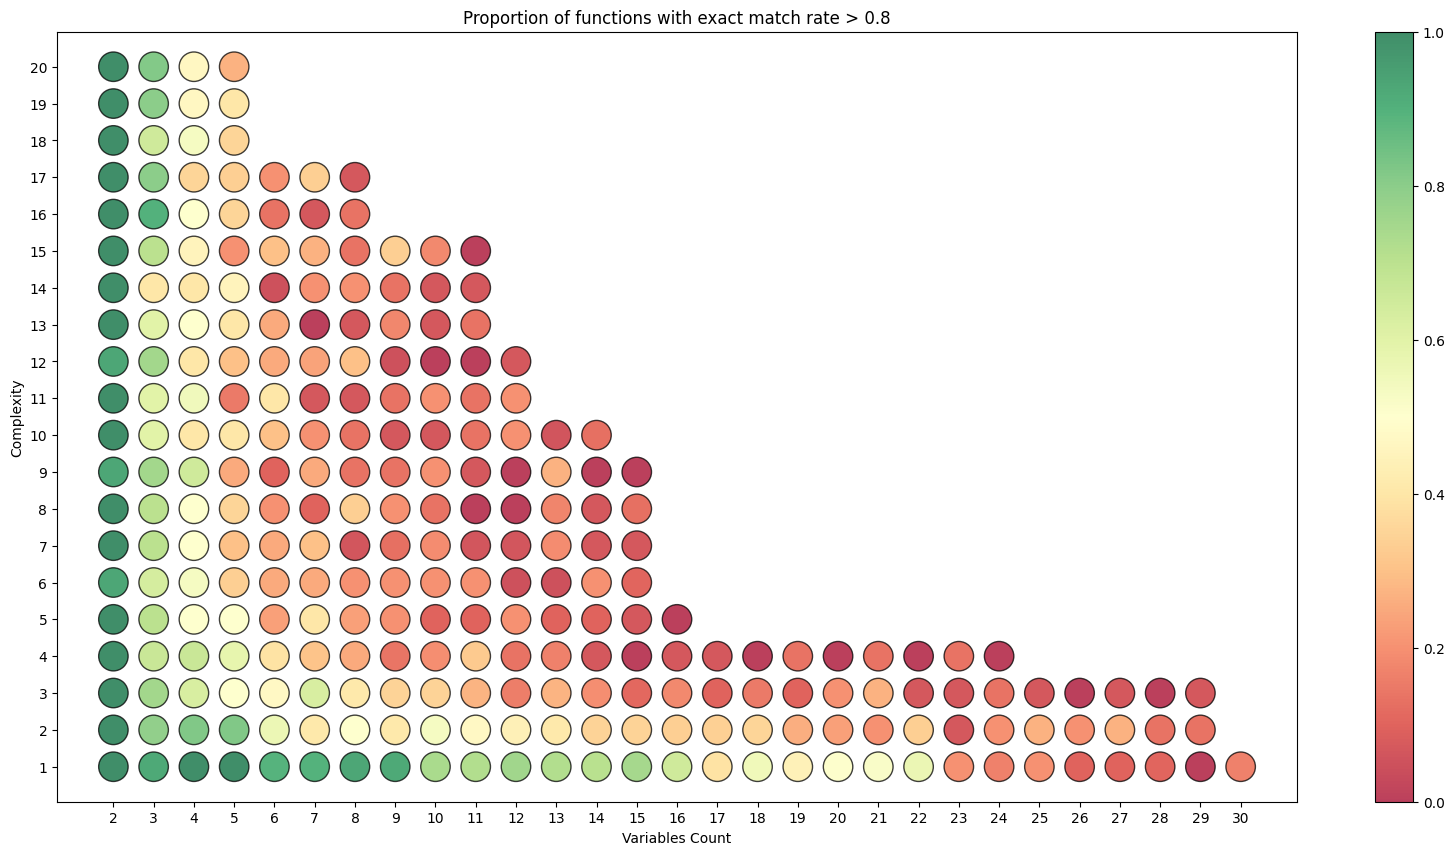

In [8]:
plot_probability_data(num_vars_data_exact, complexity_data_exact, probability_data_exact, 'Proportion of functions with exact match rate > 0.8', filepath='exact_match_rate.png')

In [ ]:
plot_probability_data(num_vars_data_hamming, complexity_data_hamming, probability_data_hamming, 'Proportion of functions with mean hamming distance < 0.2', filepath='hamming_distance.png')

In [4]:
# plot the number of functions we have data for, for each number of variables and complexity
trials = Trials()
num_vars_data = []
complexity_data = []
function_count_data = []

for num_vars in range(2, 33):
        for complexity in range(1, 22):
            with trials._connect() as conn:
                cursor = conn.cursor()
                cursor.execute("SELECT COUNT(DISTINCT statement) FROM trials WHERE num_vars = ? AND complexity = ? AND NOT counts = ''", (num_vars, complexity))
                count = cursor.fetchone()[0]
                num_vars_data.append(num_vars)
                complexity_data.append(complexity)
                function_count_data.append(count)
            print(f"(num_vars, complexity) = ({num_vars}, {complexity})")



(num_vars, complexity) = (2, 1)
(num_vars, complexity) = (2, 2)
(num_vars, complexity) = (2, 3)
(num_vars, complexity) = (2, 4)
(num_vars, complexity) = (2, 5)
(num_vars, complexity) = (2, 6)
(num_vars, complexity) = (2, 7)
(num_vars, complexity) = (2, 8)
(num_vars, complexity) = (2, 9)
(num_vars, complexity) = (2, 10)
(num_vars, complexity) = (2, 11)
(num_vars, complexity) = (2, 12)
(num_vars, complexity) = (2, 13)
(num_vars, complexity) = (2, 14)
(num_vars, complexity) = (2, 15)
(num_vars, complexity) = (2, 16)
(num_vars, complexity) = (2, 17)
(num_vars, complexity) = (2, 18)
(num_vars, complexity) = (2, 19)
(num_vars, complexity) = (2, 20)
(num_vars, complexity) = (2, 21)
(num_vars, complexity) = (3, 1)
(num_vars, complexity) = (3, 2)
(num_vars, complexity) = (3, 3)
(num_vars, complexity) = (3, 4)
(num_vars, complexity) = (3, 5)
(num_vars, complexity) = (3, 6)
(num_vars, complexity) = (3, 7)
(num_vars, complexity) = (3, 8)
(num_vars, complexity) = (3, 9)
(num_vars, complexity) = (3,

In [5]:
for i in range(len(function_count_data)):
    if function_count_data[i] > 30:
        function_count_data[i] = 30

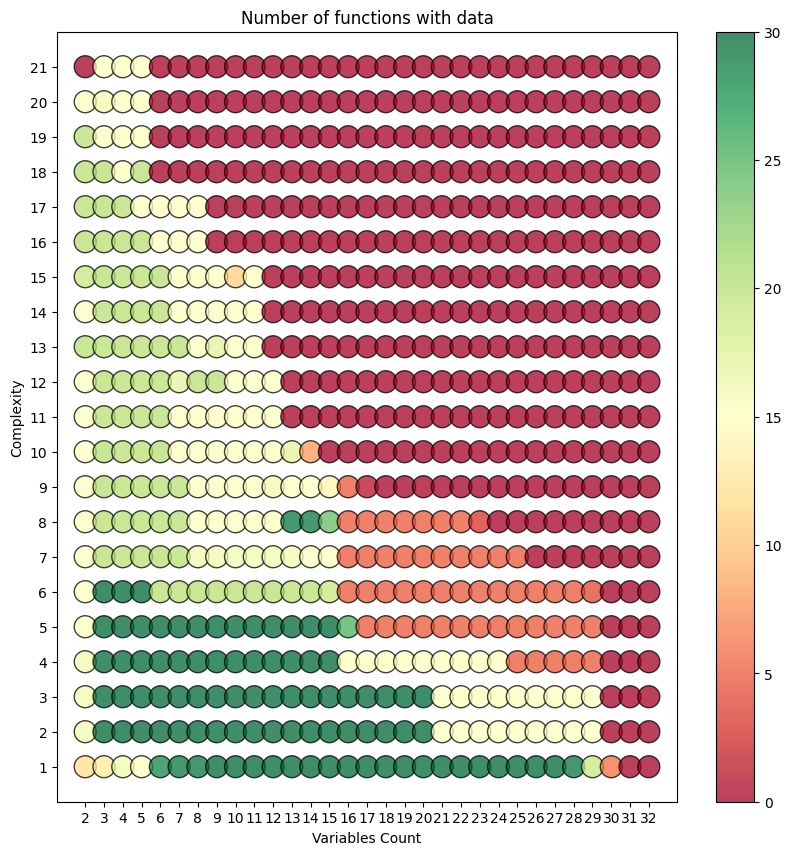

In [6]:
def plot_counts_data(num_vars_data, complexity_data, probability_data, title, threshold=None, filepath=None):
    if threshold is not None:
        colors = ['green' if p > threshold else 'red' for p in probability_data]
    else:
        colors = probability_data

    plt.figure(figsize=(10, 10))
    plt.scatter(num_vars_data, complexity_data, c=probability_data, cmap='RdYlGn', edgecolors='black', alpha=0.75, s=250)
    plt.xticks(np.arange(min(num_vars_data), max(num_vars_data) + 1, 1))
    plt.yticks(np.arange(min(complexity_data), max(complexity_data) + 1, 1))

    plt.xlabel('Variables Count')
    plt.ylabel('Complexity')
    plt.title(title)
    cbar = plt.colorbar()
    if filepath is not None:
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()
    
plot_counts_data(num_vars_data, complexity_data, function_count_data, 'Number of functions with data', filepath='function_count.png')

In [8]:
partials = []
for i in range(len(function_count_data)):
    if function_count_data[i] > 0 and function_count_data[i] < 15:
        partials.append((num_vars_data[i], complexity_data[i]))
print(partials)

[(2, 1), (3, 1), (3, 20), (5, 18), (9, 13), (9, 14), (9, 15), (10, 12), (10, 13), (10, 14), (10, 15), (11, 11), (11, 12), (11, 13), (11, 14), (11, 15), (12, 10), (12, 11), (12, 12), (13, 9), (14, 9), (14, 10), (15, 7), (15, 9), (18, 4), (19, 4), (20, 4), (21, 2), (21, 3), (21, 4), (22, 2), (22, 3), (22, 4), (23, 2), (23, 3), (23, 4), (24, 2), (24, 3), (24, 4), (25, 2), (25, 3), (26, 2), (26, 3), (27, 2), (27, 3), (28, 2), (28, 3), (29, 2), (29, 3), (30, 1)]
